# Проект: классификация

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px
from sklearn.metrics import classification_report

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [358]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [359]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [360]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [361]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

### Задание 4

In [362]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
df['balance']=df['balance'].apply(make_convert)
df['balance'].mean()


1529.1290293615875

In [363]:
df['balance']=df['balance'].fillna(df['balance'].median())
df['balance'].mean()


1526.9360329690019

### Задание 5

In [364]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
m_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)

In [365]:
mask=(df['job'] == 'management') & (df['education'] == 'secondary')
print(round(df[mask].groupby(['job', 'education'])['balance'].mean(), 3))


job         education
management  secondary    1598.883
Name: balance, dtype: float64


### Задание 6

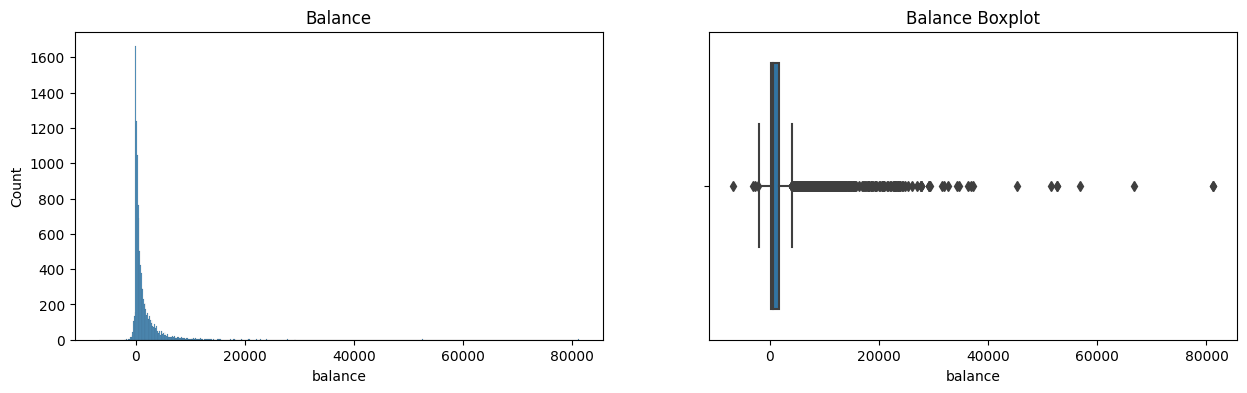

In [366]:
# удалите все выбросы для признака balance
# ваш код
#Построим гистограмму и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [367]:
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)
IQR=Q3-Q1
bound_lower = Q1 - 1.5*IQR
bound_upper=Q3 + 1.5*IQR
print(f'Нижняя граница поиска выбросов по методу Тьюкки: {bound_lower}')
print(f'Верхняя граница поиска выбросов по методу Тьюкки: {bound_upper}')

Нижняя граница поиска выбросов по методу Тьюкки: -2241.0
Верхняя граница поиска выбросов по методу Тьюкки: 4063.0


In [368]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    df_cl= data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, df_cl
outliers, df_cl = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_cl.shape[0]}')



Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


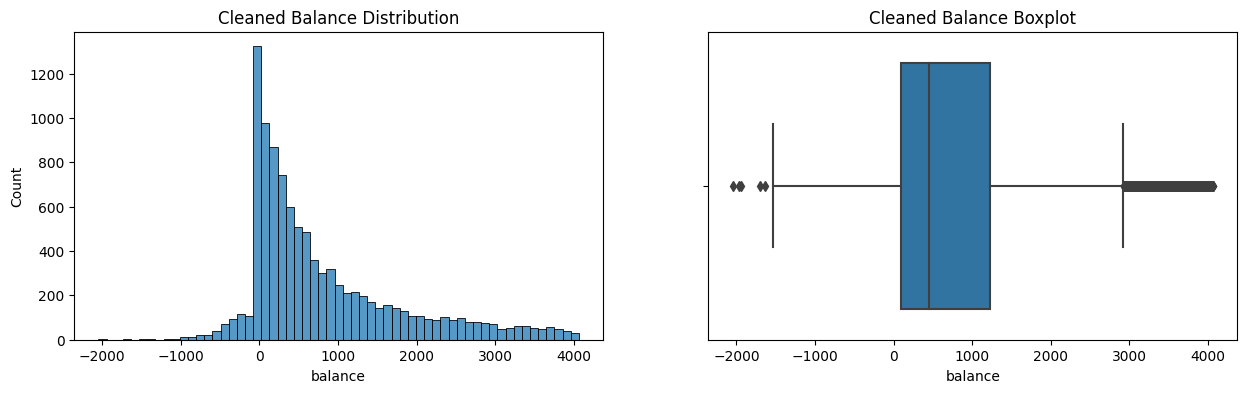

In [369]:
#построим гистограмму и боксплот на новых данных
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_cl, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Balance Distribution');
boxplot = sns.boxplot(data=df_cl, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Balance Boxplot');

## Часть 2:  Разведывательный анализ

### Задание 1

In [370]:
deposit_yes=df_cl['deposit'].value_counts()
deposit_yes


no     5424
yes    4681
Name: deposit, dtype: int64

<BarContainer object of 2 artists>

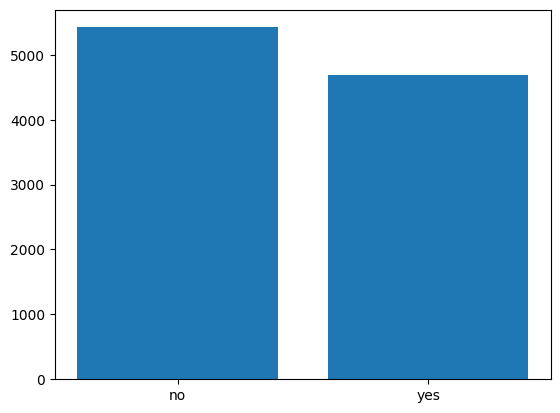

In [371]:
plt.bar(x=deposit_yes.index, height=deposit_yes.values)


### Задания 2 и 3

In [372]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
max_age=df_cl['age'].max()
print(f'Максимальный возраст клиента: {max_age}')
min_duration=df_cl['duration'].min()
print(f'Минимальная продолжительность разговора с клиентом банка: {min_duration}')

Максимальный возраст клиента: 95
Минимальная продолжительность разговора с клиентом банка: 2


### Задания 4 и 5

In [373]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
count_months=df_cl['month'].value_counts().count()
print(f'Количество месяцев, в которых проводилась маркетинговая кампания: {count_months}')

count_job=df_cl['job'].value_counts().count()
print(f'Количество сфер занятости представленных среди клиентов банка: {count_job}')

#постройте визуализации, иллюстрирующие результаты

Количество месяцев, в которых проводилась маркетинговая кампания: 12
Количество сфер занятости представленных среди клиентов банка: 11


### Задание 6

In [374]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_cl['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


<AxesSubplot: xlabel='poutcome'>

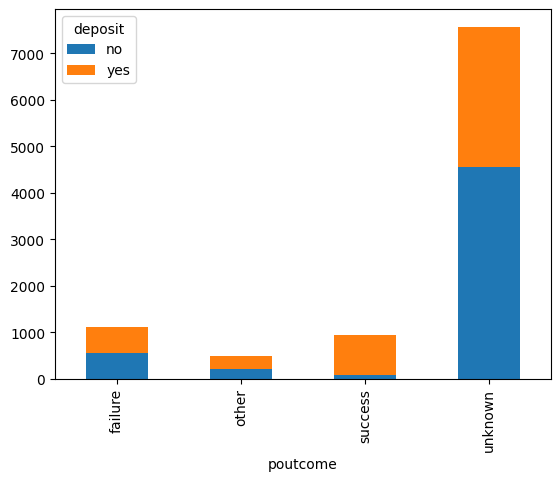

In [375]:
grouped = df_cl.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
display(grouped)
grouped.plot(kind='bar', stacked='True')

### Задание 7

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


5424

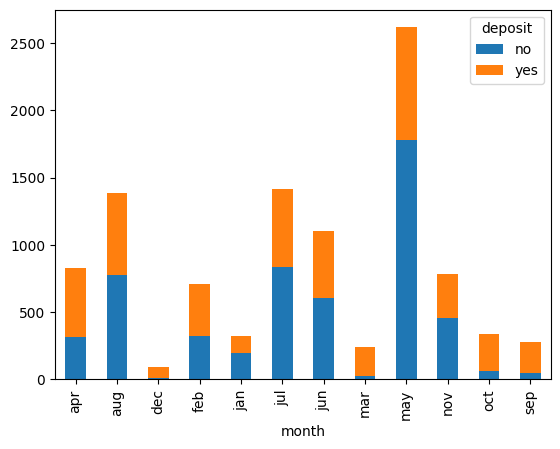

In [376]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
grouped_month = df_cl.groupby('month')['deposit'].value_counts(normalize=False).unstack()
display(grouped_month)
grouped_month.plot(kind='bar', stacked='True')
sum_no=grouped_month['no'].sum()
sum_no

### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

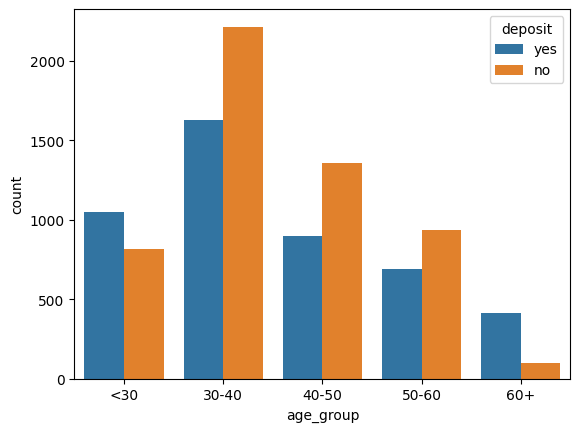

In [377]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_cl['age_group']=pd.cut(df.age, [0, 30, 40, 50, 60, 9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])
sns.countplot(x="age_group", hue="deposit", data=df_cl)

### Задания 9 и 10

In [378]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_cl['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


<AxesSubplot: xlabel='marital'>

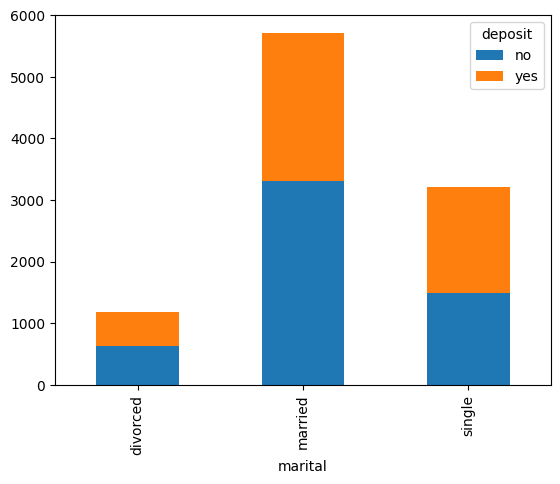

In [379]:
grouped_marital = df_cl.groupby('marital')['deposit'].value_counts(normalize=False).unstack()
display(grouped_marital)
grouped_marital.plot(kind='bar', stacked='True')

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


<AxesSubplot: xlabel='education'>

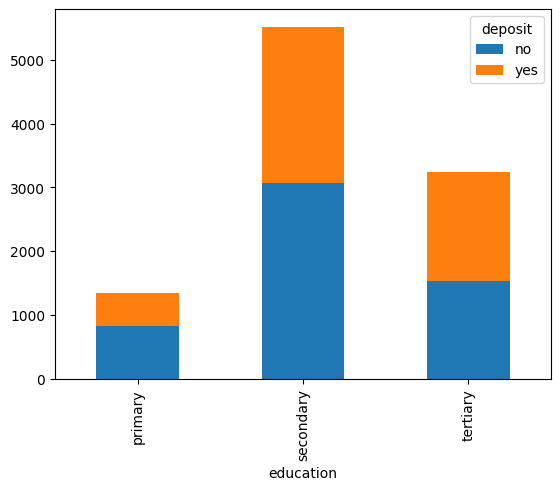

In [380]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
grouped_education = df_cl.groupby('education')['deposit'].value_counts(normalize=False).unstack()
display(grouped_education)
grouped_education.plot(kind='bar', stacked='True')

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


<AxesSubplot: xlabel='job'>

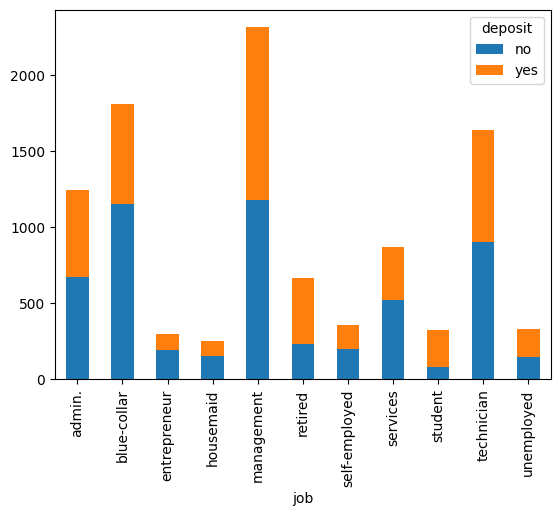

In [381]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
grouped_job = df_cl.groupby('job')['deposit'].value_counts(normalize=False).unstack()
display(grouped_job)
grouped_job.plot(kind='bar', stacked='True')

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


<AxesSubplot: xlabel='marital', ylabel='education'>

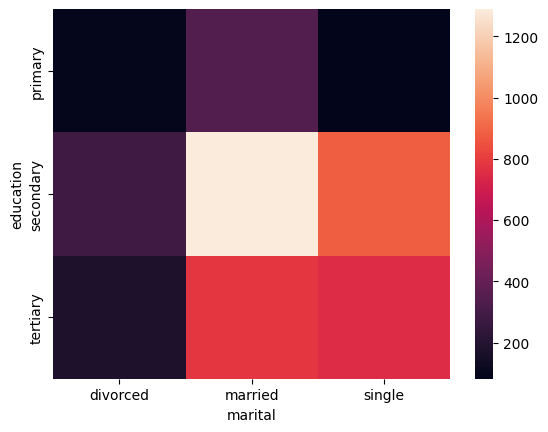

In [382]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
data_yes = df_cl[df_cl.deposit == 'yes'][['education','marital','deposit']]
data_no = df_cl[df_cl.deposit == 'no'][['education','marital','deposit']] 
res1 = pd.crosstab(data_yes['education'], data_yes['marital'])
res2 = pd.crosstab(data_no['education'], data_no['marital'])
display(res1, res2)
sns.heatmap(res1)

<AxesSubplot: xlabel='marital', ylabel='education'>

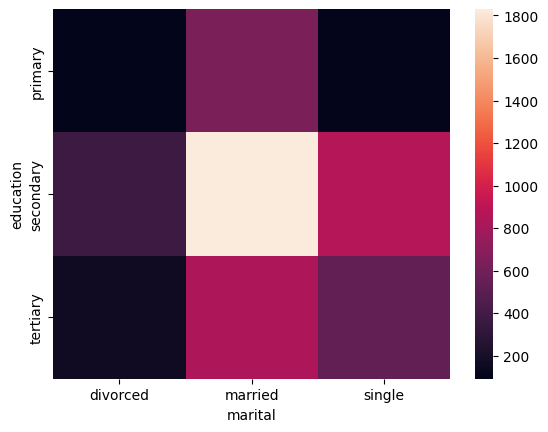

In [383]:
sns.heatmap(res2)

## Часть 3: преобразование данных

### Задание 1

In [384]:
# преобразуйте уровни образования
LE=LabelEncoder()
df_cl['education'] = LE.fit_transform(df_cl['education'])
df_cl['age_group'] = LE.fit_transform(df_cl['age_group'])
df_cl['deposit'] = LE.fit_transform(df_cl['deposit'])

In [385]:
df_cl['education'].sum()

11995

In [386]:
df_cl['deposit'].std()

0.4986712532452124

### Задания 2 и 3

In [387]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# уберем ошибочные отзывы
df_cl['default'] = LE.fit_transform(df_cl['default'])
df_cl['housing'] = LE.fit_transform(df_cl['housing'])
df_cl['loan'] = LE.fit_transform(df_cl['loan'])

In [388]:
default=df_cl['default'].mean()
housing=df_cl['housing'].mean()
loan=df_cl['loan'].mean()
sum=default+housing+loan
print(round(sum, 3))


0.635


### Задание 4

In [389]:
# создайте дамми-переменные
dummies_data = pd.get_dummies(df_cl, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)
dummies_data.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


In [390]:
dummies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<AxesSubplot: >

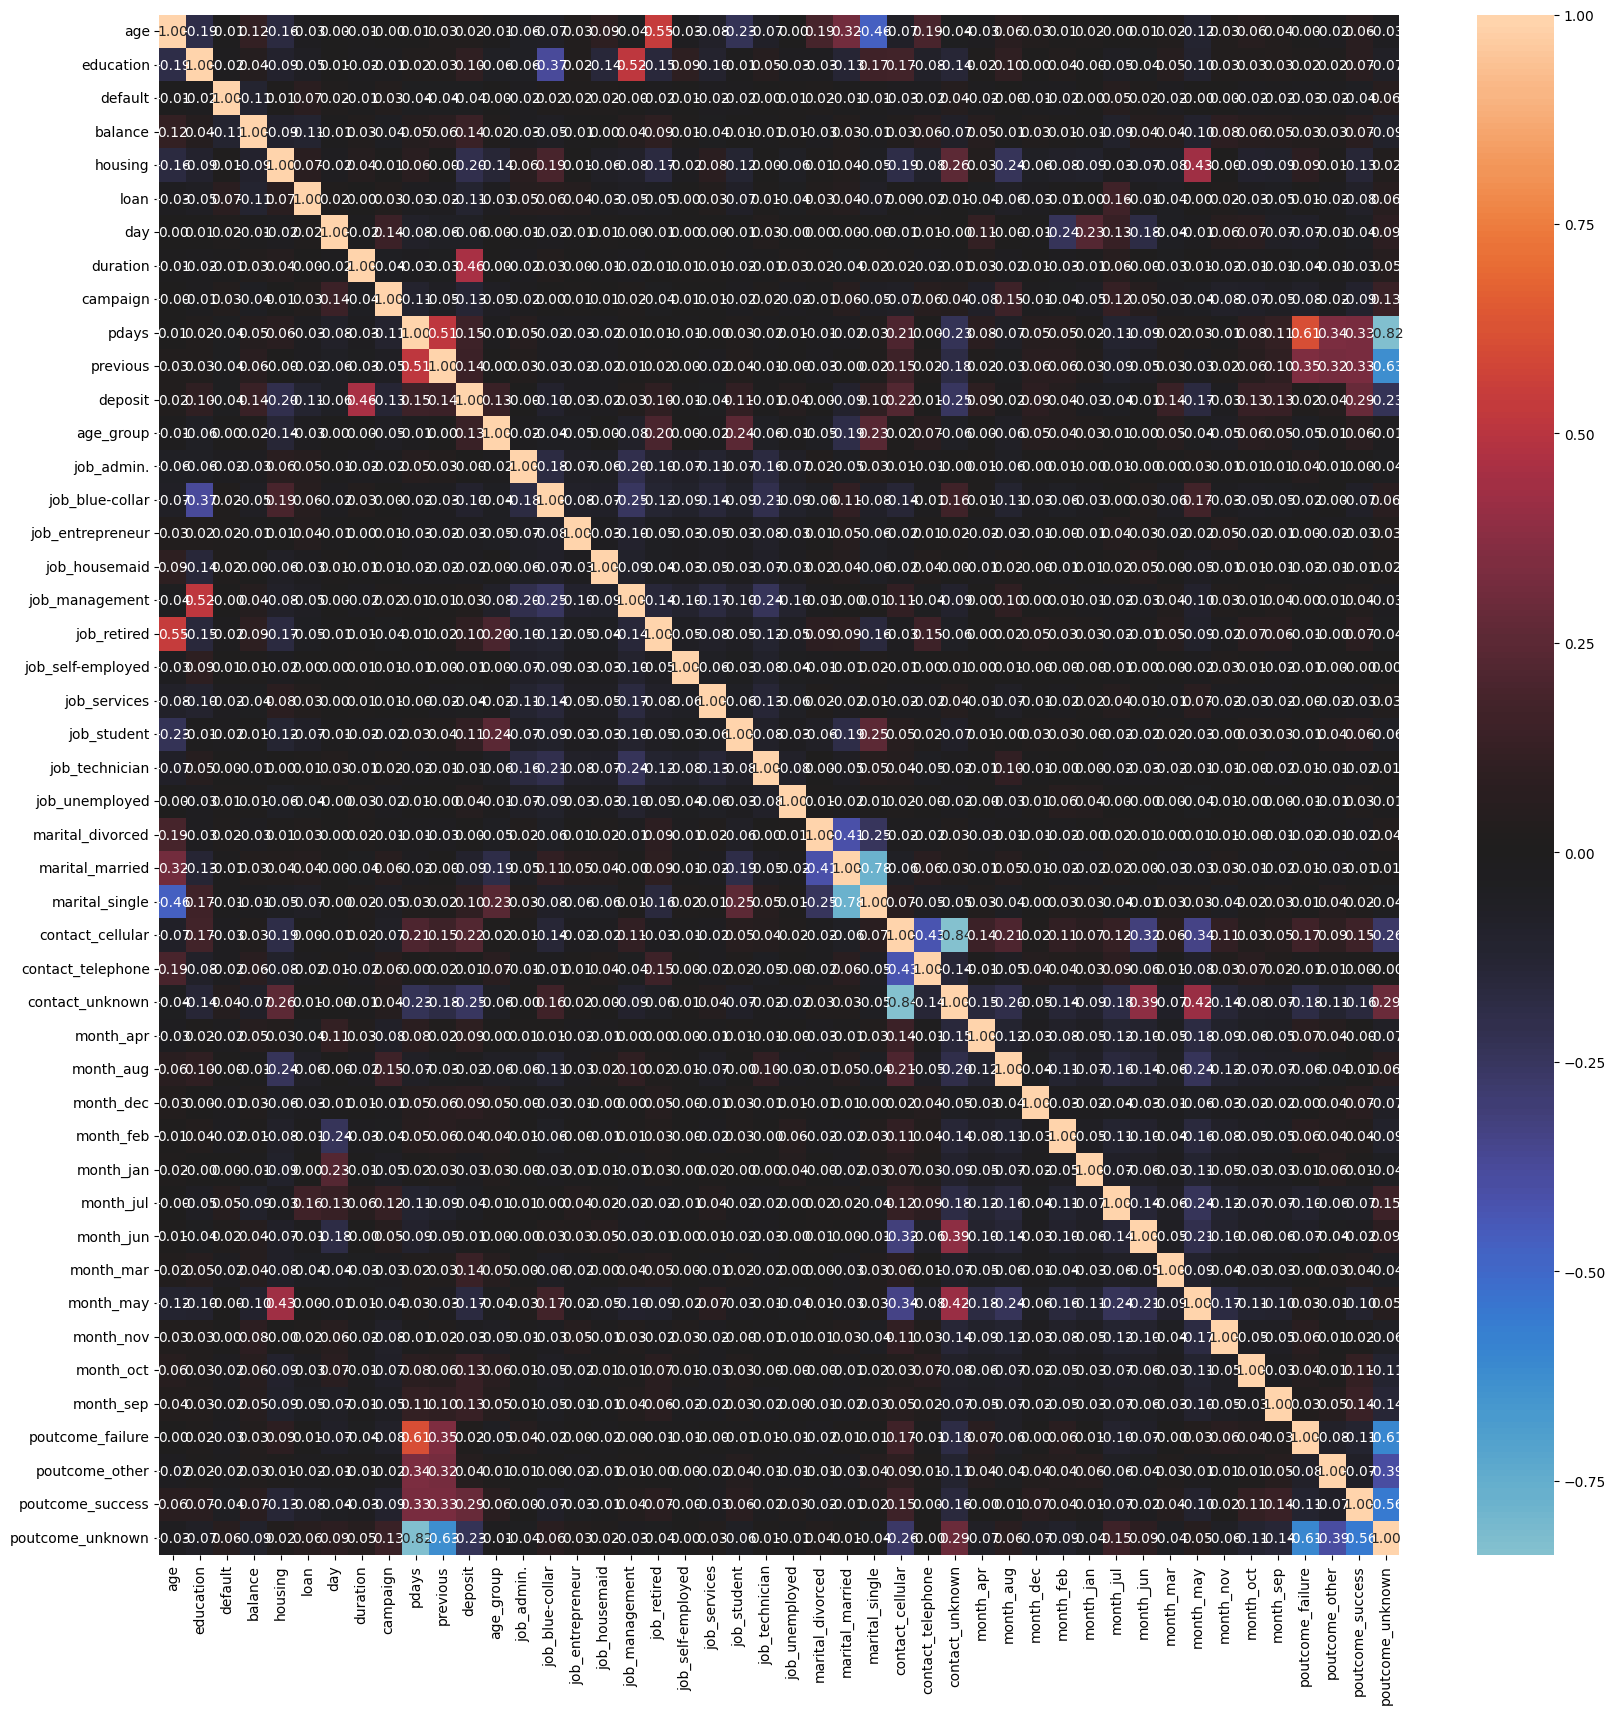

In [391]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20,20))  
sns.heatmap(dummies_data.corr(),fmt='.2f',annot=True, center=0)

### Задания 7 и 8

In [392]:
X = dummies_data.drop(['deposit'], axis=1)
y = dummies_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [393]:
# рассчитайте необходимые показатели
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_test.shape))
#y_test_mean=y_test.mean()
print('Значение целевой переменной на тестовой выборке: {}'.format(y_test.mean()))

Train shape: (6770, 45)
Valid shape: (3335, 45)
Значение целевой переменной на тестовой выборке: 0.46326836581709147


### Задание 9

In [394]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [395]:
# нормализуйте данные с помощью minmaxsxaler
data_copy=dummies_data.copy()
data_copy = data_copy[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']]
#data_copy.dropna(inplace = True)


y = data_copy['deposit']
x = data_copy.drop(columns='deposit')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [396]:
print(X_test_scaled[:, 0].mean())

0.4664194922571109


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [397]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag',
    max_iter = 1000, 
    random_state=42
    )
#Обучаем модель
log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
#Выводим значения метрик для тренировочной выборки
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для тестовой выборки
print('Test accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1598
           1       0.85      0.76      0.81      1434

    accuracy                           0.83      3032
   macro avg       0.83      0.82      0.82      3032
weighted avg       0.83      0.83      0.82      3032

Train accuracy_score: 0.81
Test accuracy_score: 0.83


### Задания 2,3,4

In [398]:
# обучите решающие деревья, настройте максимальную глубину
model1=tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
model1.fit(X_train_scaled, y_train)

y_train_pred = model1.predict(X_train_scaled)
y_test_pred = model1.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
#Выводим значения метрик для тренировочной выборки
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для тестовой выборки
print('Test accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1598
           1       0.77      0.74      0.75      1434

    accuracy                           0.77      3032
   macro avg       0.77      0.77      0.77      3032
weighted avg       0.77      0.77      0.77      3032

Train accuracy_score: 1.00
Test accuracy_score: 0.77


Переобучение, попробуем подобрать глубина дерева решений, при котором метрики будут оптимальными.

In [399]:
# обучите решающие деревья, настройте максимальную глубину
model2=tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=10
)
model2.fit(X_train_scaled, y_train)

y_train_pred = model2.predict(X_train_scaled)
y_test_pred = model2.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
#Выводим значения метрик для тренировочной выборки
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для тестовой выборки
print('Test accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1598
           1       0.79      0.80      0.80      1434

    accuracy                           0.81      3032
   macro avg       0.81      0.81      0.81      3032
weighted avg       0.81      0.81      0.81      3032

Train accuracy_score: 0.87
Test accuracy_score: 0.81


In [400]:
# обучите решающие деревья, настройте максимальную глубину
model3=tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)
model3.fit(X_train_scaled, y_train)

y_train_pred = model3.predict(X_train_scaled)
y_test_pred = model3.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
#Выводим значения метрик для тренировочной выборки
print('Train accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для тестовой выборки
print('Test accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1598
           1       0.81      0.79      0.80      1434

    accuracy                           0.81      3032
   macro avg       0.81      0.81      0.81      3032
weighted avg       0.81      0.81      0.81      3032

Train accuracy_score: 0.83
Test accuracy_score: 0.81


Оптимальная глубина дерева решений - 6 у третьей модели. Значение метрики accuracy максимально, но при этом ещё нет переобучения(т. е. не растет качество на обучающей выборке при неизменном качестве на тестовой).

### Задание 5

In [401]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': list(np.linspace(2, 5, 7, 10, dtype=int)),
              'max_depth': list(np.linspace(3, 5, 7, dtype=int))
              }           
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
y_test_pred = grid_search_tree.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 2.94 s
Wall time: 3.01 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 5, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [406]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
#Выводим значения метрик 
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1598
           1       0.80      0.84      0.82      1434

    accuracy                           0.83      3032
   macro avg       0.83      0.83      0.83      3032
weighted avg       0.83      0.83      0.83      3032



### Задания 2 и 3

In [409]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05, #темп обучения
    n_estimators = 300, #количество деревьев в ансамбле
    min_samples_leaf = 5, # минимальное число объектов в листе
    max_depth = 5,  #максимальная глубина дерева
    random_state = 42 #датчик генератора случайных 
)
    
# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание 
y_test_pred  = gb.predict(X_test_scaled)

#Выводим значения метрик 
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1598
           1       0.82      0.84      0.83      1434

    accuracy                           0.84      3032
   macro avg       0.83      0.84      0.84      3032
weighted avg       0.84      0.84      0.84      3032



### Задание 4

In [411]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        max_iter = 1000, 
        random_state=42)),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    #min_samples_leaf=5,
    max_depth=6)),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5, 
        max_depth = 5, 
        random_state = 42))
    ]

# Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
    )
# Обучаем модель
stack.fit(X_train_scaled, y_train)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1598
           1       0.82      0.84      0.83      1434

    accuracy                           0.84      3032
   macro avg       0.83      0.84      0.84      3032
weighted avg       0.84      0.84      0.84      3032



### Задание 5

<AxesSubplot: >

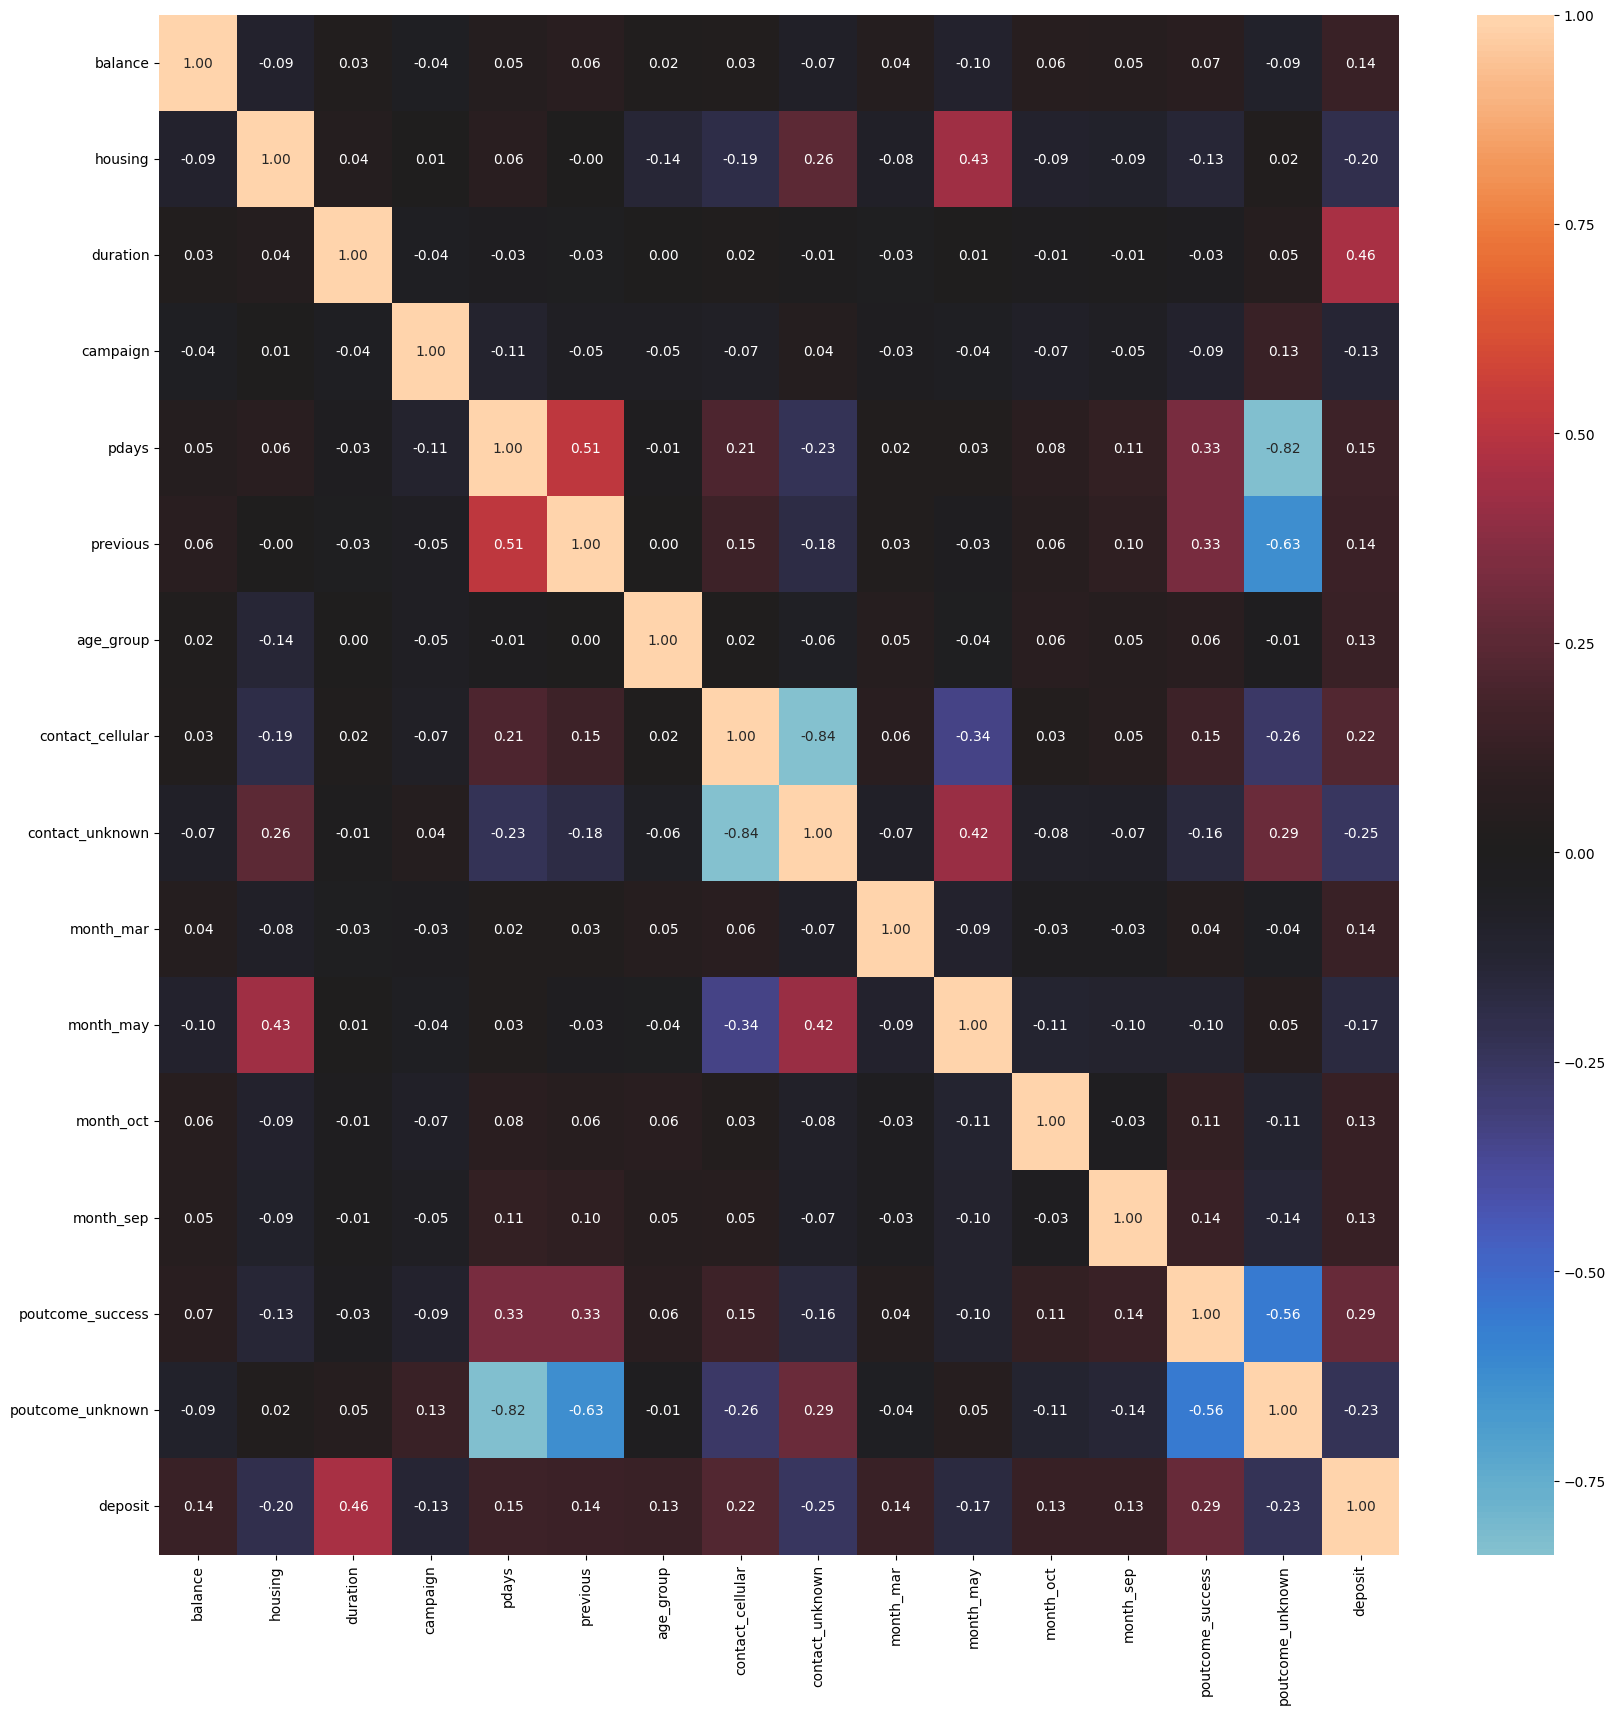

In [412]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
????
plt.figure(figsize=(20,20))  
sns.heatmap(data_copy.corr(),fmt='.2f',annot=True, center=0)

### Задания 6,7,8

In [416]:
import optuna
random_state=42
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

#%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

#%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
#study.optimize(optuna_rf, n_trials=10)

[I 2023-07-14 18:58:37,316] A new study created in memory with name: RandomForestClassifier


[I 2023-07-14 18:58:39,469] Trial 0 finished with value: 0.8741501737422571 and parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8741501737422571.
[I 2023-07-14 18:58:42,000] Trial 1 finished with value: 0.8883874849578821 and parameters: {'n_estimators': 148, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8883874849578821.
[I 2023-07-14 18:58:43,945] Trial 2 finished with value: 0.8581752484191508 and parameters: {'n_estimators': 140, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8883874849578821.
[I 2023-07-14 18:58:46,264] Trial 3 finished with value: 0.8552472858866104 and parameters: {'n_estimators': 173, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8883874849578821.
[I 2023-07-14 18:58:48,841] Trial 4 finished with value: 0.8475701780863265 and parameters: {'n_estimators': 193, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.888

Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
